In [1]:
import torch
import random
import torch.optim as optim
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import os
import sys

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from predict.features import (
    PreprocessConvFeatures,
    PreprocessDenseFeatures,
    PreprocessRNNFeatures,
    PreprocessEmbeddingFeatures,
    PreprocessLayerNormFeatures,
    PreprocessAttentionFeatures
)

layer_types = [
    'Convolution',
    'Dense',
    'RNN',
    'Embedding',
    'Attention',
    'LayerNorm'
]

layer_t = layer_types[1]

# Specify the dataset path
dataset_path = f'../data/{layer_t}.csv'

data = pd.read_csv(dataset_path)
data = data.sample(frac=1).reset_index(drop=True)

data = data.dropna()

data

,IT,batchsize,dim_input,dim_output,precision,activation_fct,optimizer,timeUsed_median,timeUsed_min,timeUsed_max,...,TMUs,ROPs,SM,TC,RT,PR,TR,FP16,FP32,FP64
0,902,60,2558,3761,32,0,0,0.118079,0.116920,0.119238,...,240,80,60,240,60,163,490,30290,30290,473
1,1440,3,2197,417,32,3,2,0.913932,0.913105,0.914760,...,160,64,40,320,40,101,254,65130,8141,254
2,12294,39,3824,1613,32,1,2,3.290851,3.283253,3.298450,...,160,64,40,320,40,101,254,65130,8141,254
3,2460,44,4085,811,32,2,0,0.165079,0.163999,0.166159,...,160,64,40,320,40,101,254,65130,8141,254
4,17432,32,4001,1294,32,1,0,0.579419,0.577712,0.581126,...,160,64,20,0,0,71,178,89,5700,178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139995,9663,46,2909,1777,32,1,0,0.076442,0.075512,0.077372,...,240,80,60,240,60,163,490,30290,30290,473
139996,16094,32,441,600,32,1,5,0.660193,0.635662,0.684724,...,192,96,48,192,48,150,300,19170,19170,300
139997,11052,21,1781,1663,32,0,0,0.203624,0.199838,0.207410,...,192,96,48,192,48,150,300,19170,19170,300
139998,7420,42,463,4064,32,3,0,0.203676,0.172672,0.234680,...,192,96,48,192,48,150,300,19170,19170,300


In [3]:
preprocessors = {
    'Convolution': PreprocessConvFeatures,
    'Dense': PreprocessDenseFeatures,
    'RNN': PreprocessRNNFeatures,
    'Embedding': PreprocessEmbeddingFeatures,
    'Attention': PreprocessAttentionFeatures,
    'LayerNorm': PreprocessLayerNormFeatures
}


preprocessor = preprocessors[layer_t](features=data, include_additional_features=True)
features = preprocessor.features

filtered_gpus = random.choices(data['GPU'].unique(), k=2)

print(f'Selected GPUs for training: {list(set(data["GPU"].unique()) - set(filtered_gpus))}')
print(f'Selected GPUs for testing: {filtered_gpus}')

filtered_features = features[features['GPU'].isin(filtered_gpus)]
features = features[~features['GPU'].isin(filtered_gpus)]

filtered_data = data[data['GPU'].isin(filtered_gpus)]
data = data[~data['GPU'].isin(filtered_gpus)] 

filtered_features = filtered_features.drop(columns=['GPU'])
features = features.drop(columns=['GPU'])

# Reset index to ensure consistency between features and labels
data = data.reset_index(drop=True)
filtered_data = filtered_data.reset_index(drop=True)

scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
filtered_features = pd.DataFrame(scaler.transform(filtered_features), columns=filtered_features.columns)

/home/ubuntu/dl-training-time-prediction/predict/features.py:387: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['None' 'Adadelta' 'Adadelta' ... 'None' 'None' 'Adadelta']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.features.loc[:, 'optimizer'] = self.features['optimizer'].map({0:'None',
/home/ubuntu/dl-training-time-prediction/predict/features.py:394: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['None' 'sigmoid' 'relu' ... 'None' 'sigmoid' 'relu']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.features.loc[:, 'activation_fct'] = self.features['activation_fct'].map({0:'None',
/home/ubuntu/dl-training-time-prediction/predict/features.py:401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

Selected GPUs for training: ['T4', 'RTX4090', 'V100', 'L4', 'P4']
Selected GPUs for testing: ['RTXA4000', 'P100']


In [4]:
X_train = features
X_test = filtered_features

y_train = data['timeUsed_median']
y_test = filtered_data['timeUsed_median']

In [5]:
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

In [6]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [7]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rms_rf = rmse(y_test, y_pred_rf)
print(f'Random Forest RMS: {rms_rf:.3f} ms')


# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
rms_gb = rmse(y_test, y_pred_gb)
print(f'Gradient Boosting RMS: {rms_gb:.3f} ms')


# XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
rms_xgb = rmse(y_test, y_pred_xgb)
print(f'XGBoost RMS: {rms_xgb:.3f} ms')

Random Forest RMS: 0.607 ms
Gradient Boosting RMS: 0.656 ms
XGBoost RMS: 1.293 ms


In [8]:
from torch.utils.data import TensorDataset, DataLoader
import torch

X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

num_epochs = 300
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [9]:
from prediction_models import (
    MLP,
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

mlp = MLP(input_size=X_train.shape[1]).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)


for epoch in tqdm(range(num_epochs)):
    mlp.train()
    epoch_loss = 0
    
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = mlp(batch_X)
        loss = criterion(outputs, batch_y.view(-1, 1))
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}] Loss: {epoch_loss/len(train_loader):.4f}')

/home/ubuntu/miniconda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  3%|▎         | 10/300 [00:40<19:38,  4.07s/it]

Epoch [9/300] Loss: 0.0172


  7%|▋         | 20/300 [01:20<18:28,  3.96s/it]

Epoch [19/300] Loss: 0.0155


 10%|█         | 30/300 [02:01<18:52,  4.19s/it]

Epoch [29/300] Loss: 0.0144


 13%|█▎        | 40/300 [02:42<17:54,  4.13s/it]

Epoch [39/300] Loss: 0.0142


 17%|█▋        | 50/300 [03:23<17:48,  4.27s/it]

Epoch [49/300] Loss: 0.0137


 20%|██        | 60/300 [04:04<16:06,  4.03s/it]

Epoch [59/300] Loss: 0.0128


 23%|██▎       | 70/300 [04:46<16:00,  4.17s/it]

Epoch [69/300] Loss: 0.0137


 27%|██▋       | 80/300 [05:26<14:59,  4.09s/it]

Epoch [79/300] Loss: 0.0123


 30%|███       | 90/300 [06:07<14:08,  4.04s/it]

Epoch [89/300] Loss: 0.0129


 33%|███▎      | 100/300 [06:47<13:07,  3.94s/it]

Epoch [99/300] Loss: 0.0120


 37%|███▋      | 110/300 [07:26<13:01,  4.11s/it]

Epoch [109/300] Loss: 0.0121


 40%|████      | 120/300 [08:06<12:05,  4.03s/it]

Epoch [119/300] Loss: 0.0121


 43%|████▎     | 130/300 [08:46<11:25,  4.04s/it]

Epoch [129/300] Loss: 0.0118


 47%|████▋     | 140/300 [09:24<10:13,  3.83s/it]

Epoch [139/300] Loss: 0.0117


 50%|█████     | 150/300 [10:05<10:04,  4.03s/it]

Epoch [149/300] Loss: 0.0121


 53%|█████▎    | 160/300 [10:43<09:00,  3.86s/it]

Epoch [159/300] Loss: 0.0116


 57%|█████▋    | 170/300 [11:23<08:33,  3.95s/it]

Epoch [169/300] Loss: 0.0115


 60%|██████    | 180/300 [12:05<08:17,  4.15s/it]

Epoch [179/300] Loss: 0.0120


 63%|██████▎   | 190/300 [12:47<07:50,  4.28s/it]

Epoch [189/300] Loss: 0.0114


 67%|██████▋   | 200/300 [13:29<06:53,  4.14s/it]

Epoch [199/300] Loss: 0.0117


 70%|███████   | 210/300 [14:11<06:12,  4.14s/it]

Epoch [209/300] Loss: 0.0118


 73%|███████▎  | 220/300 [14:53<05:32,  4.16s/it]

Epoch [219/300] Loss: 0.0117


 77%|███████▋  | 230/300 [15:32<04:21,  3.74s/it]

Epoch [229/300] Loss: 0.0115


 80%|████████  | 240/300 [16:10<03:52,  3.87s/it]

Epoch [239/300] Loss: 0.0115


 83%|████████▎ | 250/300 [16:48<02:59,  3.59s/it]

Epoch [249/300] Loss: 0.0119


 87%|████████▋ | 260/300 [17:31<02:51,  4.29s/it]

Epoch [259/300] Loss: 0.0115


 90%|█████████ | 270/300 [18:13<02:04,  4.16s/it]

Epoch [269/300] Loss: 0.0109


 93%|█████████▎| 280/300 [18:55<01:25,  4.29s/it]

Epoch [279/300] Loss: 0.0114


 97%|█████████▋| 290/300 [19:39<00:42,  4.29s/it]

Epoch [289/300] Loss: 0.0115


100%|██████████| 300/300 [20:22<00:00,  4.07s/it]

Epoch [299/300] Loss: 0.0113


In [10]:
mlp.eval()  # Set the model to evaluation mode

y_true = []
y_pred_mlp = []

with torch.no_grad():  # Disable gradient computation for evaluation
    for inputs, targets in tqdm(test_loader):  # Iterate over test_loader batches 
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        outputs = mlp(inputs).cpu().numpy()  # Get predictions and move to CPU
        y_true.extend(targets.cpu().numpy())  # Add actual values to list
        y_pred_mlp.extend(outputs)  # Add predictions to list

# Compute RMS error
rms_mlp = rmse(y_true, y_pred_mlp)
print(f'Feedforward Neural Network RMS: {rms_mlp:.3f} ms')

100%|██████████| 313/313 [00:01<00:00, 279.98it/s]


Feedforward Neural Network RMS: 0.608 ms


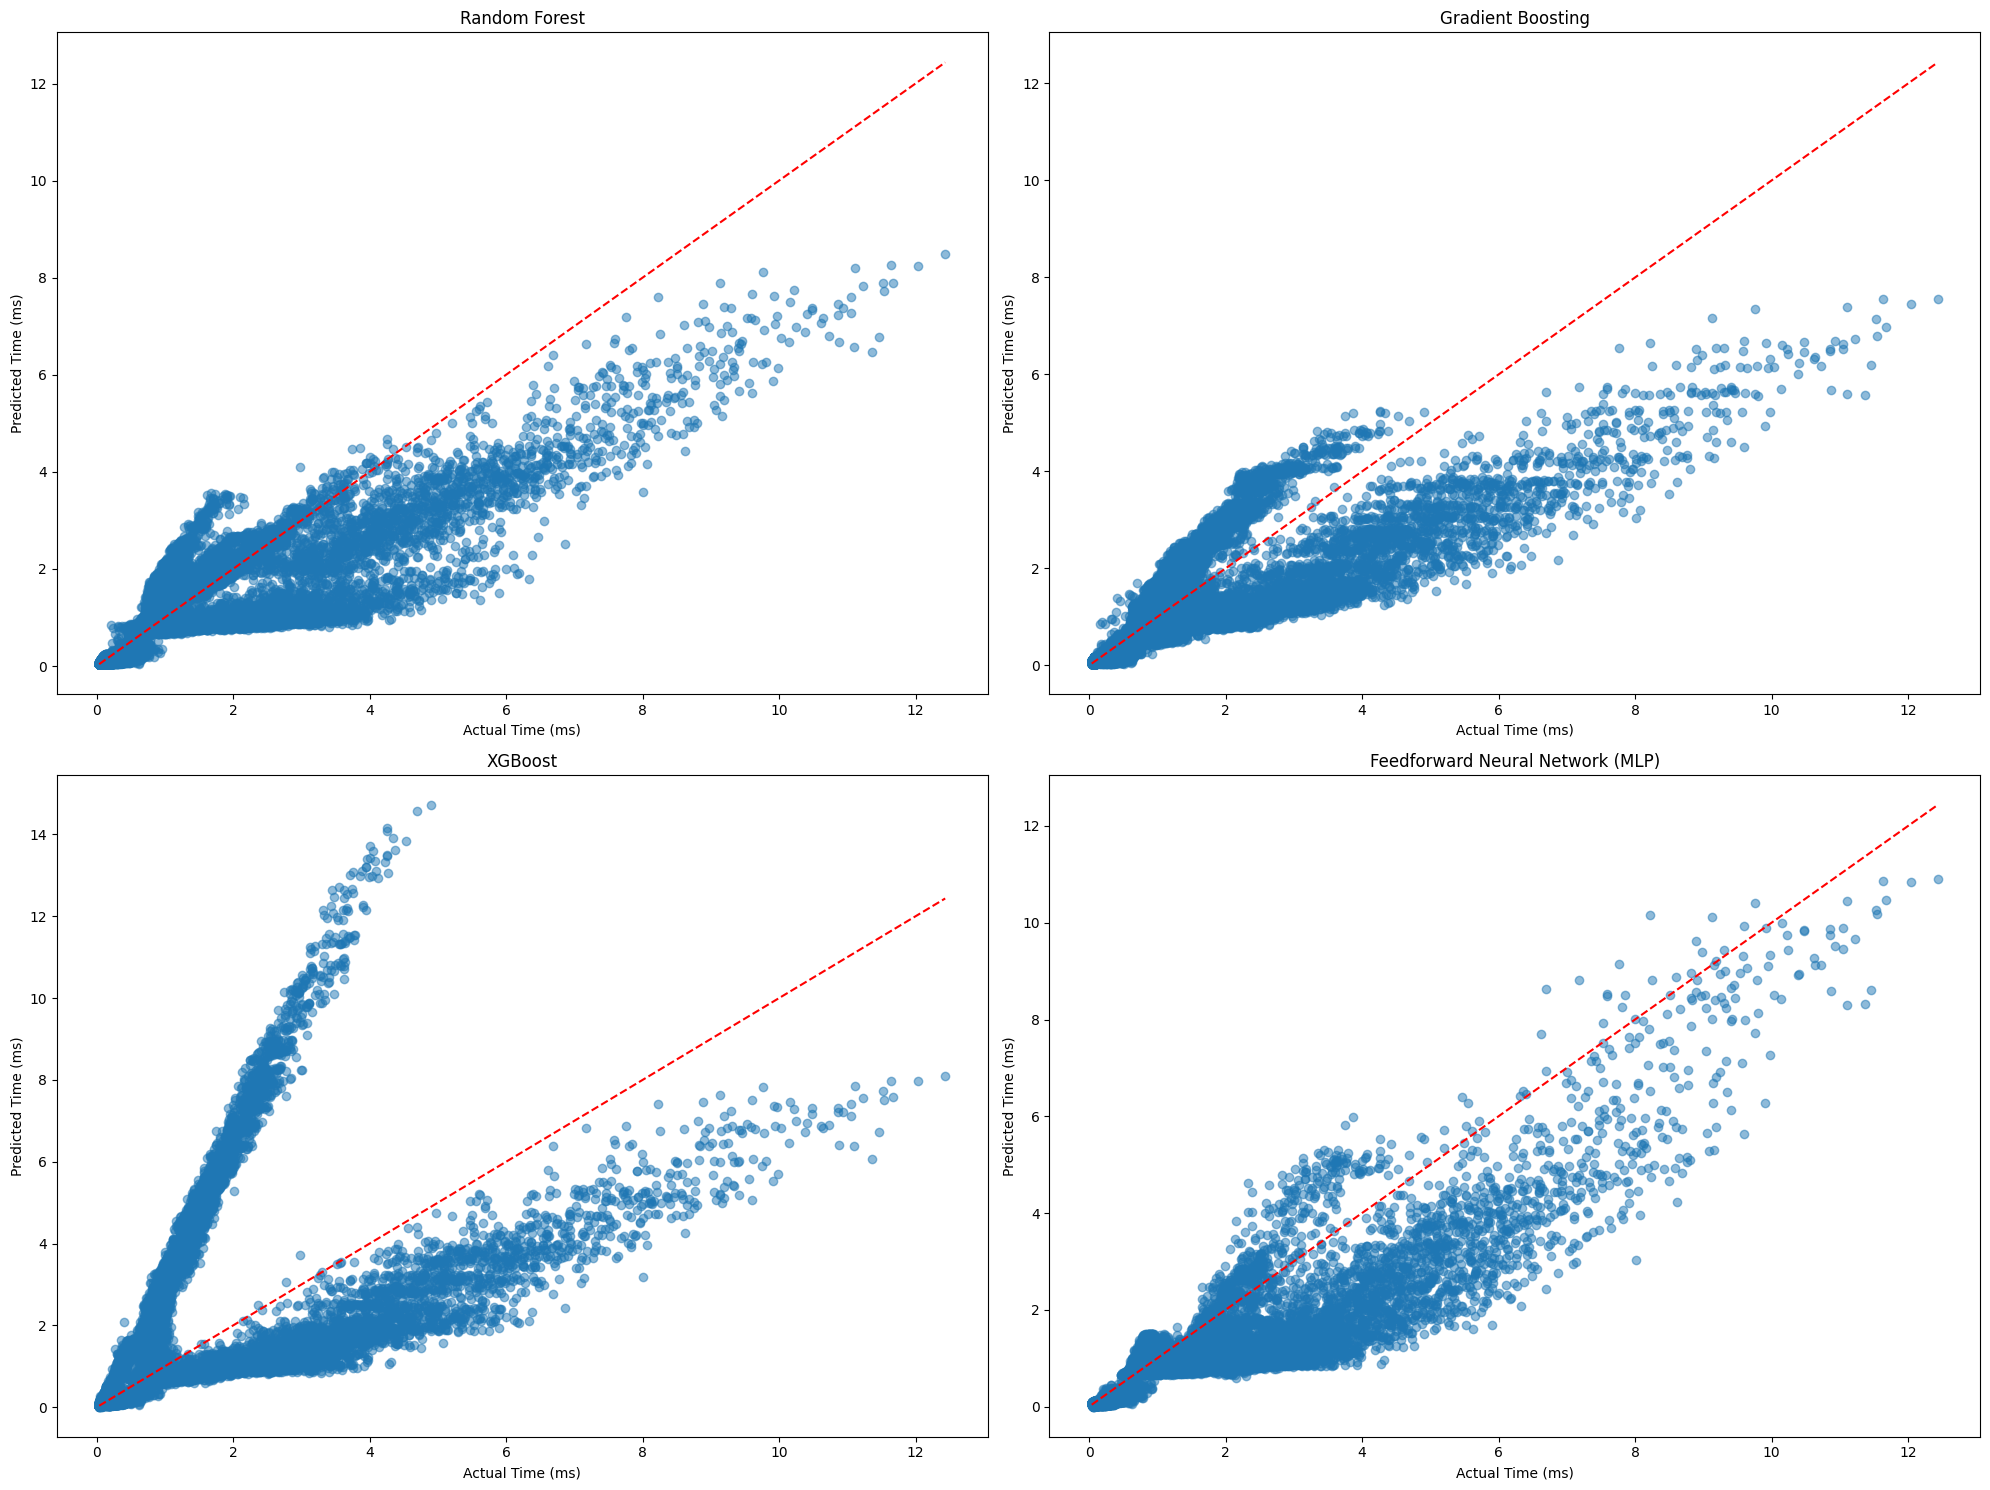

In [11]:
# Plot predicted vs actual values for all models
plt.figure(figsize=(20, 15))

# Random Forest
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Random Forest')
plt.xlabel('Actual Time (ms)')
plt.ylabel('Predicted Time (ms)')

# Gradient Boosting
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_gb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Gradient Boosting')
plt.xlabel('Actual Time (ms)')
plt.ylabel('Predicted Time (ms)')

# XGBoost
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('XGBoost')
plt.xlabel('Actual Time (ms)')
plt.ylabel('Predicted Time (ms)')

# Feedforward Neural Network (MLP)
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred_mlp, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Feedforward Neural Network (MLP)')
plt.xlabel('Actual Time (ms)')
plt.ylabel('Predicted Time (ms)')

plt.tight_layout()
plt.show()